In [27]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
data=pd.read_csv("/kaggle/input/genomics-1/AID_598_datatable.csv")

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85212 entries, 0 to 85211
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PUBCHEM_RESULT_TAG             85212 non-null  object 
 1   PUBCHEM_SID                    85210 non-null  float64
 2   PUBCHEM_CID                    85210 non-null  float64
 3   PUBCHEM_EXT_DATASOURCE_SMILES  85210 non-null  object 
 4   PUBCHEM_ACTIVITY_OUTCOME       85210 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE         85210 non-null  float64
 6   PUBCHEM_ACTIVITY_URL           0 non-null      float64
 7   PUBCHEM_ASSAYDATA_COMMENT      0 non-null      float64
 8   % Viability                    85212 non-null  object 
dtypes: float64(5), object(4)
memory usage: 5.9+ MB


In [29]:
#selecting only relavent features
data = data[["PUBCHEM_EXT_DATASOURCE_SMILES", "PUBCHEM_ACTIVITY_OUTCOME", "% Viability"]]


In [30]:
data

,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,% Viability
0,NaN,NaN,FLOAT
1,NaN,NaN,PERCENT
2,CN1C(=NC2=CC=CC=C2C1=O)/C=C/C3=CC=C(O3)[N+](=O...,Active,-0.53
3,CC1=NC(=C(N1CC(=O)C2=CC=C(C=C2)Br)Br)[N+](=O)[O-],Active,-0.43
4,COC1=C(C=C2C(=C1)C3=NN=C(C3=CN2CC4=CC=C(C=C4)F...,Active,-0.43
...,...,...,...
85207,C1CN(CCN1C(=O)CSC2=NNC(=N2)C3=CC=CS3)S(=O)(=O)...,Inactive,102.04
85208,CN1C=CC=C1C(=O)NC(=O)COC(=O)C2=C(C=CC(=C2)Cl)OC,Inactive,95.51
85209,CC1=NN=C(N1/N=C/C2=CC(=C(C=C2)OCC(=O)NC3=CC=C(...,Inactive,78.89
85210,C1C2C=CC1C3C2C(=O)N(C3=O)CC(=O)NC4=NC5=CC=CC=C5N4,Inactive,69.54


In [31]:
#removing irrelavent features
data = data.iloc[2:].reset_index(drop=True)


In [32]:
#checking classimbalance
data.PUBCHEM_ACTIVITY_OUTCOME.value_counts()

PUBCHEM_ACTIVITY_OUTCOME
Inactive    80068
Active       5142
Name: count, dtype: int64

In [33]:
#checking for null values
data.isnull().sum()

PUBCHEM_EXT_DATASOURCE_SMILES    0
PUBCHEM_ACTIVITY_OUTCOME         0
% Viability                      0
dtype: int64

In [34]:
#checking for buplicate values
duplicates = data.duplicated()
print(duplicates.sum())  # Number of duplicate rows


0


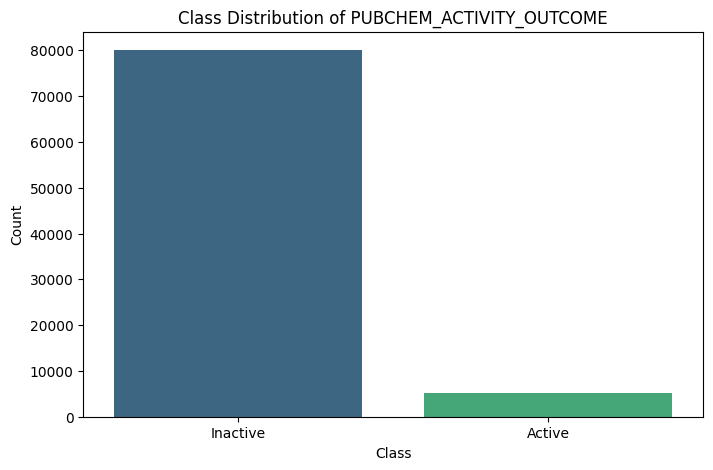

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each class
class_counts = data.PUBCHEM_ACTIVITY_OUTCOME.value_counts()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Labels and title
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution of PUBCHEM_ACTIVITY_OUTCOME")

# Show plot
plt.show()


In [36]:
!pip install rdkit

****FEATURE EXTRACTION****

In [37]:
import numpy as np
import pandas as pd
import warnings
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Crippen
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")  # Ignore warnings

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Function to compute Morgan Fingerprints
def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    return np.zeros(nBits)  # Return empty vector if invalid

# Function to compute Physicochemical Descriptors
def compute_physicochemical_props(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return [
            Descriptors.MolWt(mol),                      # Molecular Weight (MW)
            Crippen.MolLogP(mol),                        # LogP (Lipophilicity)
            Descriptors.TPSA(mol),                       # Topological Polar Surface Area (TPSA)
            Descriptors.NumHDonors(mol),                 # Hydrogen Bond Donors (HBD)
            Descriptors.NumHAcceptors(mol),              # Hydrogen Bond Acceptors (HBA)
            Descriptors.NumRotatableBonds(mol),          # Rotatable Bonds
            Descriptors.NumAromaticRings(mol)            # Aromatic Rings
        ]
    return [0] * 7  # Return zeros if invalid

#  Extract Features
print("Extracting Features...")
y = data["PUBCHEM_ACTIVITY_OUTCOME"].map({"Inactive": 0, "Active": 1}).values
# Extract Morgan fingerprints (2048 bits)
X_fingerprints = np.array([smiles_to_fingerprint(smi) for smi in data["PUBCHEM_EXT_DATASOURCE_SMILES"]])

# Extract physicochemical descriptors (7 features)
X_physicochem = np.array([compute_physicochemical_props(smi) for smi in data["PUBCHEM_EXT_DATASOURCE_SMILES"]])

# Extract % Viability
X_viability = data["% Viability"].values.reshape(-1, 1)

# Combine all features into a single DataFrame
fingerprints_df = pd.DataFrame(X_fingerprints, columns=[f"FP_{i}" for i in range(X_fingerprints.shape[1])])
physicochem_df = pd.DataFrame(X_physicochem, columns=["MolWt", "LogP", "TPSA", "NumHDonors", "NumHAcceptors", "NumRotatableBonds", "NumAromaticRings"])
viability_df = pd.DataFrame(X_viability, columns=["% Viability"])

# Concatenate all extracted features into a final DataFrame
features_df = pd.concat([fingerprints_df, physicochem_df, viability_df], axis=1)

# Print the first few rows of the DataFrame
print("Extracted Features DataFrame:")
print(features_df.head())

# Optionally, you can scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

# Show the final scaled feature matrix shape
print(f"Scaled Features Shape: {X_scaled.shape}")


from imblearn.under_sampling import RandomUnderSampler

# Apply Random Undersampling to balance the dataset
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)  # Use scaled features here

# 📊 Check the class distribution after balancing
print(f"Class distribution after undersampling: {pd.Series(y_resampled).value_counts()}")


Extracting Features...
Extracted Features DataFrame:
   FP_0  FP_1  FP_2  FP_3  FP_4  FP_5  FP_6  FP_7  FP_8  FP_9  ...  FP_2046  \
0     0     0     0     0     0     0     0     0     0     0  ...        0   
1     0     0     0     0     0     0     0     0     0     0  ...        0   
2     0     0     0     0     0     0     0     0     0     0  ...        0   
3     0     0     0     0     0     0     0     0     0     0  ...        0   
4     0     0     0     0     0     0     0     0     0     0  ...        0   

   FP_2047    MolWt     LogP   TPSA  NumHDonors  NumHAcceptors  \
0        0  297.270  2.60510  91.17         0.0            6.0   
1        0  403.030  3.50762  78.03         0.0            5.0   
2        0  431.442  5.54680  49.17         0.0            5.0   
3        0  338.794  4.16490  64.68         1.0            3.0   
4        0  371.270  4.34470  59.92         0.0            5.0   

   NumRotatableBonds  NumAromaticRings  % Viability  
0                3.0 

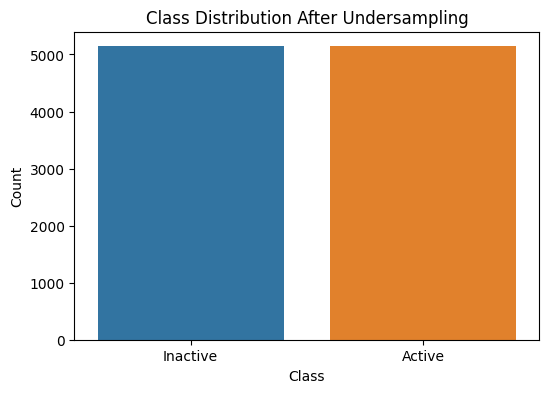

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ploting the class distribution after balancing
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title("Class Distribution After Undersampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Inactive", "Active"])
plt.show()


****SPLITTING DATASET****

In [39]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print(f"Training Set Shape: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test Set Shape: X_test = {X_test.shape}, y_test = {y_test.shape}")


Training Set Shape: X_train = (8227, 2056), y_train = (8227,)
Test Set Shape: X_test = (2057, 2056), y_test = (2057,)


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9674
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1029
           1       0.97      0.97      0.97      1028

    accuracy                           0.97      2057
   macro avg       0.97      0.97      0.97      2057
weighted avg       0.97      0.97      0.97      2057

Confusion Matrix:
 [[994  35]
 [ 32 996]]


In [41]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, X_resampled, y_resampled, cv=5, scoring="accuracy")
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Cross-Validation Accuracy: 0.9703 ± 0.0050


In [ ]:
****Your cross-validation accuracy (97.00% ± 0.0056) is almost the same as your test accuracy (96.74%), meaning your model is performing consistently across different subsets of the data.so not overfitting****

In [42]:
# Evaluate model on training set
y_train_pred = clf.predict(X_train)

# Print training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Print test accuracy (already calculated)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9930
Test Accuracy: 0.9674


In [43]:

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




### Train Logistic Regression ###
log_reg = LogisticRegression(max_iter=1000, solver="liblinear", penalty="l2")
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)




print("\n logistic Regression Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))




 logistic Regression Classifier
Accuracy: 0.6665
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.83      0.71      1029
           1       0.75      0.50      0.60      1028

    accuracy                           0.67      2057
   macro avg       0.69      0.67      0.66      2057
weighted avg       0.69      0.67      0.66      2057

Confusion Matrix:
 [[ 948   81]
 [   8 1020]]


In [44]:
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn_clf.predict(X_test)

# Evaluate the model
print("\n K-Nearest Neighbors (KNN) Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))



 K-Nearest Neighbors (KNN) Classifier
Accuracy: 0.6665
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.83      0.71      1029
           1       0.75      0.50      0.60      1028

    accuracy                           0.67      2057
   macro avg       0.69      0.67      0.66      2057
weighted avg       0.69      0.67      0.66      2057

Confusion Matrix:
 [[857 172]
 [514 514]]


In [45]:
from sklearn.svm import SVC

# Train an SVM Classifier
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_clf.predict(X_test)

# Evaluate the model
print("\n Support Vector Machine (SVM) Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))



 Support Vector Machine (SVM) Classifier
Accuracy: 0.9524
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      1029
           1       0.92      0.99      0.95      1028

    accuracy                           0.95      2057
   macro avg       0.95      0.95      0.95      2057
weighted avg       0.95      0.95      0.95      2057

Confusion Matrix:
 [[ 944   85]
 [  13 1015]]


In [46]:
#fnn model

Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6548 - loss: 0.6966 - val_accuracy: 0.8425 - val_loss: 0.3813
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9400 - loss: 0.1594 - val_accuracy: 0.9159 - val_loss: 0.2534
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 0.0812 - val_accuracy: 0.9319 - val_loss: 0.2239
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9848 - loss: 0.0486 - val_accuracy: 0.9310 - val_loss: 0.2253
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.0456 - val_accuracy: 0.9373 - val_loss: 0.2049
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0332 - val_accuracy: 0.9397 - val_loss: 0.2033
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - loss: 0.0348 - val_accuracy: 0.9431 - val_loss: 0.2020
Epoch 8/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9917 - loss: 0.0253 - val_accuracy: 0

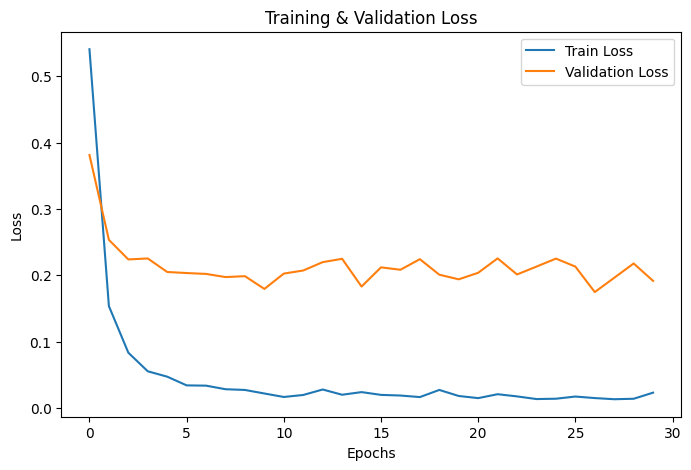

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Building Deep Learning Model
model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)),  # Input Layer
    BatchNormalization(),
    Dropout(0.3),  # Prevent Overfitting

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation="sigmoid")  # Output Layer (Binary Classification)
])

# Compiling Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Training the  Model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Making Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

#Evaluation
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Ploting Training & Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


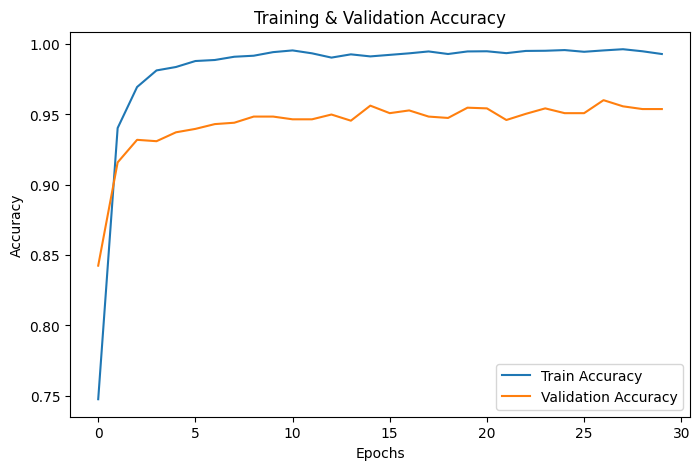

In [48]:
#  Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()